In [117]:
%load_ext autoreload
%autoreload 2
import os
import copy
import scipy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack
from astropy.stats import sigma_clip
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
from unagi import hsc
from unagi import mask
from unagi.task import hsc_cutout, hsc_tricolor, hsc_psf, hsc_check_coverage
from unagi.sky import SkyObjs, AperPhot, S18A_APER, S18A_APER_ID

# Setup HSC server
s18a = hsc.Hsc(dr='dr2', rerun='s18a_wide', verbose=False)

# Initialize skyobj catalog
sky_cat_use = Table.read('./Catalog/s18a_wide_fdfc_skyobject_flux.fits', format='fits')
sky = SkyObjs(sky_cat_use)

In [14]:
from lvhuo.stack import Stack, StackSky, StackStar
from lvhuo.display import (display_single, display_multiple, \
                           draw_circles, draw_rectangles, SEG_CMAP)
from lvhuo.image import query_star, extract_obj
from lvhuo.mock import single_sersic_galaxy

In [158]:
skyobj_cat = Table(sky.skyobjs[np.random.randint(10000, size=100)])

In [159]:
obj = skyobj_cat[0]
obj_coord = SkyCoord(ra=obj['ra'], dec=obj['dec'], frame='icrs', unit='deg')
hdu = hsc_cutout(obj_coord, cutout_size=2 * u.arcmin, filters='i', archive=s18a, 
                     output_dir='./Images/')

# Retrieving cutout image in filter: i


In [160]:
sersic_cat = Table.read('./Catalog/sersic_cat.fits')
galaxy = sersic_cat[0]

In [161]:
median_psf = fits.open('./median_psf.fits')[0].data
gal_params = {'sersic_n': galaxy['GALINDEX_r'],
              'gal_q': 1 - galaxy['GALELLIP_r'],
              'gal_beta': galaxy['GALPA_r'],
              'gal_rh': galaxy['GALRE_r'], 'gal_flux': 10**((27.0 - galaxy['GALMAG_r']) / 2.5)}

"""About Noise
boy = skyobj_cat[0]
aper57 = S18A_APER['aper57']
sigma = sky.select_circle(boy['ra'], boy['dec'],
                          radius=2 * u.arcmin).flux_stats(aper57, 'i')['std']
"""
sgal = single_sersic_galaxy(gal_params, size=hdu[1].data.shape, pixel_scale=0.168, 
                            psf_custom=median_psf, pixel_unit=True, add_noise=0)

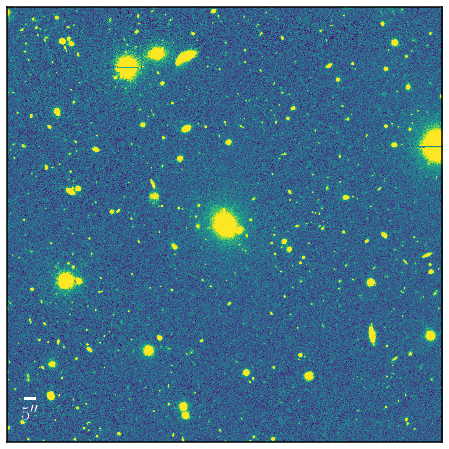

In [162]:
display_single(hdu[1].data + sgal.array);

# GAMA catalog

In [191]:
gama_cat = Table.read('./Catalog/gama_dr3_z_0.55_sersic_logms.fits')

In [192]:
gama_cat = gama_cat[(gama_cat['Z'] < 0.3) & (gama_cat['Z'] > 0.25) & (gama_cat['logmstar'] > 11.0)]

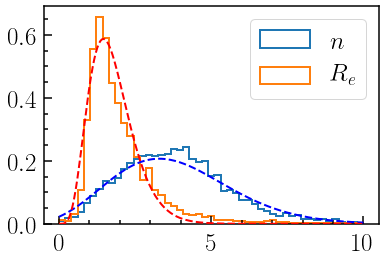

In [362]:
count, bin_edge, patches= plt.hist(gama_cat['GALINDEX_r'], 
                                     bins=np.linspace(0, 10, 50), 
                                     histtype='step', linewidth=2, density=True, label=r'$n$');
bin_middle = (bin_edge[:-1] + bin_edge[1:])/2
from scipy.optimize import curve_fit
from scipy.special import factorial
# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)
# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middle, count) 

x_plot = np.linspace(0, 10, 200)
plt.plot(x_plot, poisson(x_plot, *parameters), 'b--', lw=2, zorder=10)
n_random = np.random.gamma(*parameters, size=[1000])


count, bin_edge, patches = plt.hist(gama_cat['GALRE_r'], 
                                     bins=np.linspace(0, 10, 50), 
                                     histtype='step', linewidth=2, density=True, label=r'$R_e$');
bin_middle = (bin_edge[:-1] + bin_edge[1:])/2
from scipy.stats import gamma
# poisson function, parameter lamb is the fit parameter
def gamma_pdf(x, a, sca):
    return gamma.pdf(x, a, scale=sca, loc=0)
# fit with curve_fit
parameters, cov_matrix = curve_fit(gamma_pdf, bin_middle, count) 

x_plot = np.linspace(0, 10, 200)
plt.plot(x_plot, gamma_pdf(x_plot, *parameters), 'r--', lw=2, zorder=10)
rh_random = np.random.gamma(*parameters, size=[1000])

plt.legend()
plt.savefig('./Figures/gama_z03_m11_distribution.png', bbox_inches='tight')


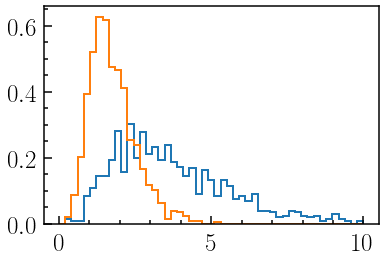

In [368]:
plt.hist(n_random, bins=np.linspace(0, 10, 50), 
         density=True, histtype='step', lw=2);
plt.hist(rh_random, bins=np.linspace(0, 10, 50), 
         density=True, histtype='step', lw=2);